# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [16]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

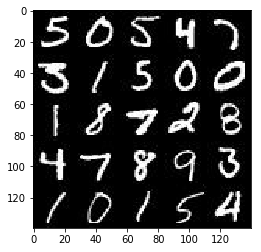

In [17]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

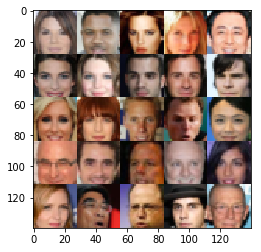

In [18]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [19]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [20]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='inputs_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='inputs_z')
    learning_rate = tf.placeholder(tf.float32, None, name='learning_rate')
    
    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [31]:
def leakyReLU(x, alpha=0.2):
    return tf.maximum(alpha * x, x)


def discriminator(images, alpha=0.2, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s) //dataset will be in the range of -0.5 to 0.5 of 28x28
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # Improvements: use odd-sized filters. Kernel size of 5 is a better choice nstead of 4.
    
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x3
        c1 = tf.layers.conv2d(images, filters=64, kernel_size=(5,5), strides=(2,2), padding='same')
        relu1 = leakyReLU(c1, alpha)
    
        #print(relu1.shape)
        # now 14x14x64
        
        c2 = tf.layers.conv2d(relu1, filters=128, kernel_size=(5,5), strides=(2,2), padding='same')
        bn2 = tf.layers.batch_normalization(c2, training=True)
        relu2 = leakyReLU(bn2, alpha)
        
        #print(relu2.shape)
        # now 7x7x128
        
        c3 = tf.layers.conv2d(relu2, filters=256, kernel_size=(5,5), strides=(2,2), padding='same')
        bn3 = tf.layers.batch_normalization(c3, training=True)
        relu3 = leakyReLU(bn3, alpha)
        
        #print(relu3.shape)
        # now 4x4x256

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

AssertionError: tf.variable_scope called with wrong arguments in Discriminator Training(reuse=false)

### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [22]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    reuse = not is_train
    alpha=0.2
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        x1 = tf.layers.dense(z, 4*4*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 4, 4, 512))
        bn1 = tf.layers.batch_normalization(x1, training=is_train)
        relu1 = leakyReLU(bn1)
        #print(relu1.shape)
        # 4x4x512 now
        
        x2 = tf.layers.conv2d_transpose(relu1, 256, 4, strides=1, padding='valid')
        bn2 = tf.layers.batch_normalization(x2, training=is_train)
        relu2 = leakyReLU(bn2)
        #print(relu2.shape)
        # 7x7x256 now
        
        x3 = tf.layers.conv2d_transpose(relu2, 128, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=is_train)
        relu3 = leakyReLU(bn3)
        #print(relu3.shape)
        # 14x14x256 now
    
        # Output layer
        logits = tf.layers.conv2d_transpose(relu3, out_channel_dim, 5, strides=2, padding='same')
        #print(logits.shape)
        # 28x28xoutput_dim now
        
        out = tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [23]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    # smothing labels
    smooth = 0.0
    
    d_out_real, d_logits_real = discriminator(input_real, reuse=False)
    g_out_fake = generator(input_z, out_channel_dim, is_train=True)
    d_out_fake, d_logits_fake = discriminator(g_out_fake, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                                labels=tf.ones_like(d_out_real) * (1 - smooth)))
    
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                labels=tf.zeros_like(d_out_fake)))
    
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                labels=tf.ones_like(d_out_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [24]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function

    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

    return None, None


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [25]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [26]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
   
    
    #? tf.reset_default_graph()
    print(data_shape)
    _, image_width, image_height, image_channels = data_shape
    
    # get placeholders
    input_real, input_z, lr = model_inputs(image_width, image_height, image_channels, z_dim)
    
    # get losses
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    
    # get optimizers    
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    # Train Model
    print_every = 25
    show_every = 200
    saver = tf.train.Saver()
    
    steps = 0
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                # TODO: Train Model
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, 
                                               input_z: batch_z, 
                                               lr:learning_rate})
                
                _ = sess.run(g_opt, feed_dict={input_real: batch_images,
                                               input_z: batch_z, 
                                               lr:learning_rate})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_real: batch_images,
                                                input_z: batch_z, 
                                                lr:learning_rate})
                    
                    train_loss_g = g_loss.eval({input_real: batch_images,
                                                input_z: batch_z, 
                                                lr:learning_rate})

                    print("Epoch: {}/{};".format(epoch_i+1, epochs),
                          "Batch: {:5d};".format(steps),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, 25, input_z, image_channels, data_image_mode)

                    
        saver.save(sess, './generator.ckpt')


### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

(60000, 28, 28, 1)
Epoch: 1/2; Batch:    25; Discriminator Loss: 1.1412... Generator Loss: 0.4959
Epoch: 1/2; Batch:    50; Discriminator Loss: 1.2714... Generator Loss: 2.2199
Epoch: 1/2; Batch:    75; Discriminator Loss: 0.5620... Generator Loss: 1.9692
Epoch: 1/2; Batch:   100; Discriminator Loss: 1.0916... Generator Loss: 0.6873
Epoch: 1/2; Batch:   125; Discriminator Loss: 1.2390... Generator Loss: 0.4348
Epoch: 1/2; Batch:   150; Discriminator Loss: 1.1338... Generator Loss: 1.9526
Epoch: 1/2; Batch:   175; Discriminator Loss: 0.8477... Generator Loss: 0.7912
Epoch: 1/2; Batch:   200; Discriminator Loss: 0.8349... Generator Loss: 1.9196


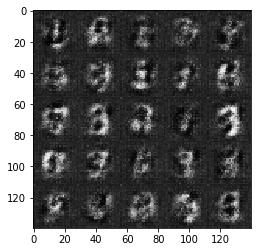

Epoch: 1/2; Batch:   225; Discriminator Loss: 0.6259... Generator Loss: 1.0780
Epoch: 1/2; Batch:   250; Discriminator Loss: 1.1157... Generator Loss: 0.4600
Epoch: 1/2; Batch:   275; Discriminator Loss: 0.4174... Generator Loss: 1.7491
Epoch: 1/2; Batch:   300; Discriminator Loss: 1.2503... Generator Loss: 0.3914
Epoch: 1/2; Batch:   325; Discriminator Loss: 0.8395... Generator Loss: 0.7656
Epoch: 1/2; Batch:   350; Discriminator Loss: 0.4591... Generator Loss: 3.2386
Epoch: 1/2; Batch:   375; Discriminator Loss: 0.4324... Generator Loss: 1.3492
Epoch: 1/2; Batch:   400; Discriminator Loss: 0.7359... Generator Loss: 0.8342


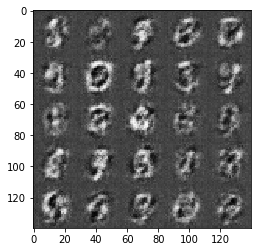

Epoch: 1/2; Batch:   425; Discriminator Loss: 0.4258... Generator Loss: 1.3216
Epoch: 1/2; Batch:   450; Discriminator Loss: 0.3212... Generator Loss: 2.9329
Epoch: 1/2; Batch:   475; Discriminator Loss: 0.2938... Generator Loss: 2.0034
Epoch: 1/2; Batch:   500; Discriminator Loss: 0.4116... Generator Loss: 1.5157
Epoch: 1/2; Batch:   525; Discriminator Loss: 0.2337... Generator Loss: 2.1216
Epoch: 1/2; Batch:   550; Discriminator Loss: 0.2203... Generator Loss: 2.3921
Epoch: 1/2; Batch:   575; Discriminator Loss: 0.3172... Generator Loss: 1.6624
Epoch: 1/2; Batch:   600; Discriminator Loss: 0.1978... Generator Loss: 2.5083


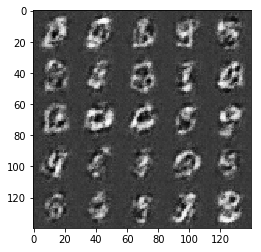

Epoch: 1/2; Batch:   625; Discriminator Loss: 0.1891... Generator Loss: 2.3600
Epoch: 1/2; Batch:   650; Discriminator Loss: 0.1686... Generator Loss: 2.3425
Epoch: 1/2; Batch:   675; Discriminator Loss: 0.1890... Generator Loss: 2.2485
Epoch: 1/2; Batch:   700; Discriminator Loss: 1.5739... Generator Loss: 0.2932
Epoch: 1/2; Batch:   725; Discriminator Loss: 0.1378... Generator Loss: 2.6123
Epoch: 1/2; Batch:   750; Discriminator Loss: 0.1174... Generator Loss: 3.0112
Epoch: 1/2; Batch:   775; Discriminator Loss: 0.1404... Generator Loss: 2.4949
Epoch: 1/2; Batch:   800; Discriminator Loss: 0.2441... Generator Loss: 2.0037


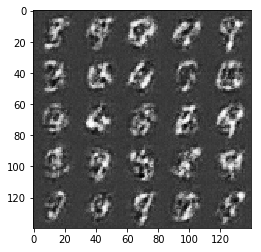

Epoch: 1/2; Batch:   825; Discriminator Loss: 0.1536... Generator Loss: 2.5419
Epoch: 1/2; Batch:   850; Discriminator Loss: 0.1499... Generator Loss: 2.3973
Epoch: 1/2; Batch:   875; Discriminator Loss: 0.1406... Generator Loss: 2.4914
Epoch: 1/2; Batch:   900; Discriminator Loss: 0.0997... Generator Loss: 2.8569
Epoch: 1/2; Batch:   925; Discriminator Loss: 0.1148... Generator Loss: 2.8825
Epoch: 2/2; Batch:   950; Discriminator Loss: 0.1212... Generator Loss: 4.0128
Epoch: 2/2; Batch:   975; Discriminator Loss: 0.1108... Generator Loss: 3.7304
Epoch: 2/2; Batch:  1000; Discriminator Loss: 0.1465... Generator Loss: 2.5549


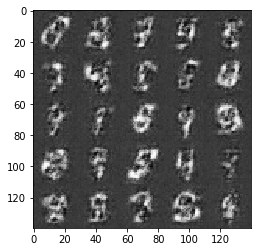

Epoch: 2/2; Batch:  1025; Discriminator Loss: 0.1869... Generator Loss: 2.1185
Epoch: 2/2; Batch:  1050; Discriminator Loss: 0.0969... Generator Loss: 2.9496
Epoch: 2/2; Batch:  1075; Discriminator Loss: 0.3422... Generator Loss: 2.2366
Epoch: 2/2; Batch:  1100; Discriminator Loss: 0.1736... Generator Loss: 2.2608
Epoch: 2/2; Batch:  1125; Discriminator Loss: 0.1570... Generator Loss: 2.3437
Epoch: 2/2; Batch:  1150; Discriminator Loss: 0.1297... Generator Loss: 2.5364
Epoch: 2/2; Batch:  1175; Discriminator Loss: 0.1853... Generator Loss: 2.1455
Epoch: 2/2; Batch:  1200; Discriminator Loss: 0.1433... Generator Loss: 2.4518


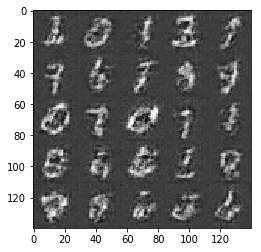

Epoch: 2/2; Batch:  1225; Discriminator Loss: 0.1089... Generator Loss: 2.9210
Epoch: 2/2; Batch:  1250; Discriminator Loss: 0.0969... Generator Loss: 2.9428
Epoch: 2/2; Batch:  1275; Discriminator Loss: 0.0990... Generator Loss: 2.8329
Epoch: 2/2; Batch:  1300; Discriminator Loss: 0.1184... Generator Loss: 2.8222
Epoch: 2/2; Batch:  1325; Discriminator Loss: 0.1182... Generator Loss: 2.7017
Epoch: 2/2; Batch:  1350; Discriminator Loss: 0.1475... Generator Loss: 2.4001
Epoch: 2/2; Batch:  1375; Discriminator Loss: 0.0771... Generator Loss: 3.2931
Epoch: 2/2; Batch:  1400; Discriminator Loss: 0.0573... Generator Loss: 4.5813


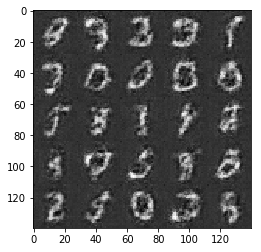

Epoch: 2/2; Batch:  1425; Discriminator Loss: 0.1149... Generator Loss: 2.7495
Epoch: 2/2; Batch:  1450; Discriminator Loss: 3.0552... Generator Loss: 3.9962
Epoch: 2/2; Batch:  1475; Discriminator Loss: 0.4506... Generator Loss: 1.4347
Epoch: 2/2; Batch:  1500; Discriminator Loss: 0.3193... Generator Loss: 1.5611
Epoch: 2/2; Batch:  1525; Discriminator Loss: 0.2540... Generator Loss: 1.8129
Epoch: 2/2; Batch:  1550; Discriminator Loss: 0.1941... Generator Loss: 2.1093
Epoch: 2/2; Batch:  1575; Discriminator Loss: 0.1411... Generator Loss: 2.4663
Epoch: 2/2; Batch:  1600; Discriminator Loss: 0.1500... Generator Loss: 2.3333


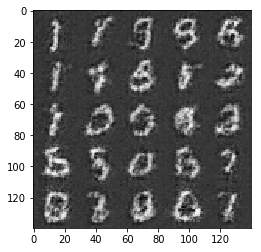

Epoch: 2/2; Batch:  1625; Discriminator Loss: 0.1396... Generator Loss: 2.5873
Epoch: 2/2; Batch:  1650; Discriminator Loss: 0.1815... Generator Loss: 2.3742
Epoch: 2/2; Batch:  1675; Discriminator Loss: 0.1982... Generator Loss: 2.0541
Epoch: 2/2; Batch:  1700; Discriminator Loss: 0.1311... Generator Loss: 2.4841
Epoch: 2/2; Batch:  1725; Discriminator Loss: 0.1590... Generator Loss: 2.6404
Epoch: 2/2; Batch:  1750; Discriminator Loss: 0.0472... Generator Loss: 3.6518
Epoch: 2/2; Batch:  1775; Discriminator Loss: 0.1242... Generator Loss: 2.4954
Epoch: 2/2; Batch:  1800; Discriminator Loss: 0.0954... Generator Loss: 3.2439


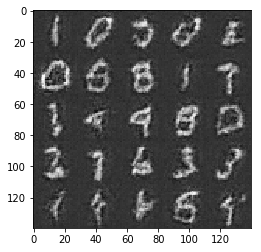

Epoch: 2/2; Batch:  1825; Discriminator Loss: 0.0979... Generator Loss: 3.0698
Epoch: 2/2; Batch:  1850; Discriminator Loss: 0.0782... Generator Loss: 3.1580


In [27]:
batch_size = 32
z_dim = 200
learning_rate = 0.001
beta1 = 0.2
# ==> Generator Loss gets bigger over, imgages gets bader

batch_size = 32
z_dim = 200
learning_rate = 0.0001
beta1 = 0.2

batch_size = 64
z_dim = 100
learning_rate = 0.0001
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

(202599, 28, 28, 3)
Epoch: 1/1; Batch:    25; Discriminator Loss: 1.5606... Generator Loss: 0.4736
Epoch: 1/1; Batch:    50; Discriminator Loss: 0.9314... Generator Loss: 0.9722
Epoch: 1/1; Batch:    75; Discriminator Loss: 0.8847... Generator Loss: 1.3329
Epoch: 1/1; Batch:   100; Discriminator Loss: 0.6329... Generator Loss: 1.3460
Epoch: 1/1; Batch:   125; Discriminator Loss: 0.5458... Generator Loss: 1.4360
Epoch: 1/1; Batch:   150; Discriminator Loss: 0.2876... Generator Loss: 1.9246
Epoch: 1/1; Batch:   175; Discriminator Loss: 0.3926... Generator Loss: 2.0287
Epoch: 1/1; Batch:   200; Discriminator Loss: 0.2996... Generator Loss: 2.3173


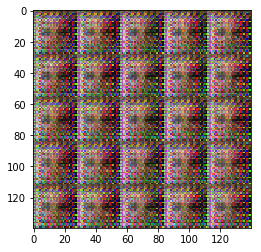

Epoch: 1/1; Batch:   225; Discriminator Loss: 0.2803... Generator Loss: 2.1829
Epoch: 1/1; Batch:   250; Discriminator Loss: 0.1414... Generator Loss: 2.8850
Epoch: 1/1; Batch:   275; Discriminator Loss: 0.2183... Generator Loss: 2.2742
Epoch: 1/1; Batch:   300; Discriminator Loss: 0.2478... Generator Loss: 1.9411
Epoch: 1/1; Batch:   325; Discriminator Loss: 0.2491... Generator Loss: 2.5163
Epoch: 1/1; Batch:   350; Discriminator Loss: 0.1185... Generator Loss: 2.8971
Epoch: 1/1; Batch:   375; Discriminator Loss: 0.1725... Generator Loss: 2.4541
Epoch: 1/1; Batch:   400; Discriminator Loss: 0.1840... Generator Loss: 2.4715


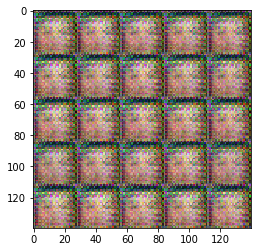

Epoch: 1/1; Batch:   425; Discriminator Loss: 0.1196... Generator Loss: 3.2144
Epoch: 1/1; Batch:   450; Discriminator Loss: 0.2083... Generator Loss: 2.5393
Epoch: 1/1; Batch:   475; Discriminator Loss: 0.4089... Generator Loss: 6.0196
Epoch: 1/1; Batch:   500; Discriminator Loss: 0.2299... Generator Loss: 2.8351
Epoch: 1/1; Batch:   525; Discriminator Loss: 0.2841... Generator Loss: 1.7820
Epoch: 1/1; Batch:   550; Discriminator Loss: 0.4393... Generator Loss: 2.7568
Epoch: 1/1; Batch:   575; Discriminator Loss: 0.3634... Generator Loss: 2.4213
Epoch: 1/1; Batch:   600; Discriminator Loss: 0.2803... Generator Loss: 1.8607


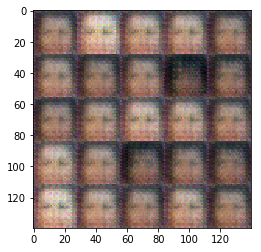

Epoch: 1/1; Batch:   625; Discriminator Loss: 1.2787... Generator Loss: 0.4495
Epoch: 1/1; Batch:   650; Discriminator Loss: 0.4620... Generator Loss: 4.2035
Epoch: 1/1; Batch:   675; Discriminator Loss: 0.2478... Generator Loss: 2.0374
Epoch: 1/1; Batch:   700; Discriminator Loss: 0.2588... Generator Loss: 2.3130
Epoch: 1/1; Batch:   725; Discriminator Loss: 0.5044... Generator Loss: 1.2958
Epoch: 1/1; Batch:   750; Discriminator Loss: 0.2005... Generator Loss: 2.3818
Epoch: 1/1; Batch:   775; Discriminator Loss: 0.8735... Generator Loss: 4.1426
Epoch: 1/1; Batch:   800; Discriminator Loss: 0.4209... Generator Loss: 1.3920


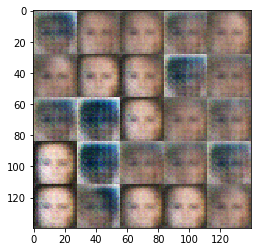

Epoch: 1/1; Batch:   825; Discriminator Loss: 0.1196... Generator Loss: 4.2255
Epoch: 1/1; Batch:   850; Discriminator Loss: 0.2508... Generator Loss: 6.7775
Epoch: 1/1; Batch:   875; Discriminator Loss: 0.3688... Generator Loss: 1.4494
Epoch: 1/1; Batch:   900; Discriminator Loss: 0.2267... Generator Loss: 8.6366
Epoch: 1/1; Batch:   925; Discriminator Loss: 0.5145... Generator Loss: 5.9503
Epoch: 1/1; Batch:   950; Discriminator Loss: 0.8913... Generator Loss: 9.3619
Epoch: 1/1; Batch:   975; Discriminator Loss: 0.2377... Generator Loss: 9.2007
Epoch: 1/1; Batch:  1000; Discriminator Loss: 0.2571... Generator Loss: 8.1607


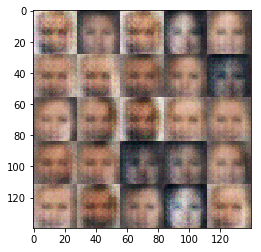

Epoch: 1/1; Batch:  1025; Discriminator Loss: 0.0548... Generator Loss: 6.9963
Epoch: 1/1; Batch:  1050; Discriminator Loss: 0.0401... Generator Loss: 5.4788
Epoch: 1/1; Batch:  1075; Discriminator Loss: 0.1538... Generator Loss: 8.5197
Epoch: 1/1; Batch:  1100; Discriminator Loss: 0.6679... Generator Loss: 0.9342
Epoch: 1/1; Batch:  1125; Discriminator Loss: 0.0237... Generator Loss: 5.3037
Epoch: 1/1; Batch:  1150; Discriminator Loss: 0.4417... Generator Loss: 1.3251
Epoch: 1/1; Batch:  1175; Discriminator Loss: 0.0515... Generator Loss: 7.6252
Epoch: 1/1; Batch:  1200; Discriminator Loss: 1.0369... Generator Loss: 10.8420


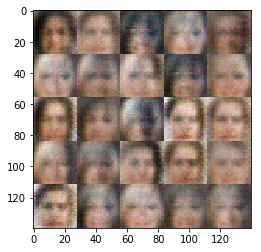

Epoch: 1/1; Batch:  1225; Discriminator Loss: 0.0943... Generator Loss: 10.4658
Epoch: 1/1; Batch:  1250; Discriminator Loss: 0.0323... Generator Loss: 7.0482
Epoch: 1/1; Batch:  1275; Discriminator Loss: 1.0155... Generator Loss: 0.5452
Epoch: 1/1; Batch:  1300; Discriminator Loss: 0.0899... Generator Loss: 8.4928
Epoch: 1/1; Batch:  1325; Discriminator Loss: 0.0461... Generator Loss: 5.4717
Epoch: 1/1; Batch:  1350; Discriminator Loss: 0.2133... Generator Loss: 8.5414
Epoch: 1/1; Batch:  1375; Discriminator Loss: 0.1778... Generator Loss: 2.4936
Epoch: 1/1; Batch:  1400; Discriminator Loss: 0.3413... Generator Loss: 1.4304


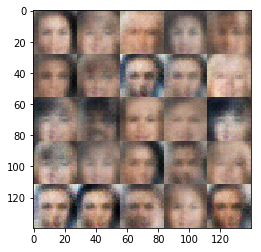

Epoch: 1/1; Batch:  1425; Discriminator Loss: 1.5352... Generator Loss: 0.2833
Epoch: 1/1; Batch:  1450; Discriminator Loss: 0.1225... Generator Loss: 4.8279
Epoch: 1/1; Batch:  1475; Discriminator Loss: 1.1437... Generator Loss: 0.4715
Epoch: 1/1; Batch:  1500; Discriminator Loss: 0.3375... Generator Loss: 1.5486
Epoch: 1/1; Batch:  1525; Discriminator Loss: 0.0095... Generator Loss: 6.1283
Epoch: 1/1; Batch:  1550; Discriminator Loss: 0.5478... Generator Loss: 0.9754
Epoch: 1/1; Batch:  1575; Discriminator Loss: 0.1032... Generator Loss: 5.9482
Epoch: 1/1; Batch:  1600; Discriminator Loss: 0.0359... Generator Loss: 4.4841


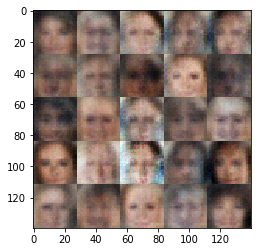

Epoch: 1/1; Batch:  1625; Discriminator Loss: 0.0924... Generator Loss: 8.4841
Epoch: 1/1; Batch:  1650; Discriminator Loss: 0.0898... Generator Loss: 6.5966
Epoch: 1/1; Batch:  1675; Discriminator Loss: 0.0977... Generator Loss: 6.8220
Epoch: 1/1; Batch:  1700; Discriminator Loss: 1.3412... Generator Loss: 11.6351
Epoch: 1/1; Batch:  1725; Discriminator Loss: 0.1530... Generator Loss: 2.4383
Epoch: 1/1; Batch:  1750; Discriminator Loss: 0.9229... Generator Loss: 0.7579
Epoch: 1/1; Batch:  1775; Discriminator Loss: 0.0496... Generator Loss: 5.7698
Epoch: 1/1; Batch:  1800; Discriminator Loss: 0.2230... Generator Loss: 13.2207


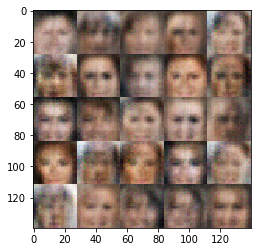

Epoch: 1/1; Batch:  1825; Discriminator Loss: 0.0630... Generator Loss: 5.3058
Epoch: 1/1; Batch:  1850; Discriminator Loss: 0.0242... Generator Loss: 10.8338
Epoch: 1/1; Batch:  1875; Discriminator Loss: 0.0761... Generator Loss: 8.9760
Epoch: 1/1; Batch:  1900; Discriminator Loss: 0.0376... Generator Loss: 9.0083
Epoch: 1/1; Batch:  1925; Discriminator Loss: 0.0452... Generator Loss: 5.0753
Epoch: 1/1; Batch:  1950; Discriminator Loss: 0.0366... Generator Loss: 8.6430
Epoch: 1/1; Batch:  1975; Discriminator Loss: 0.0243... Generator Loss: 7.6254
Epoch: 1/1; Batch:  2000; Discriminator Loss: 0.0195... Generator Loss: 8.2303


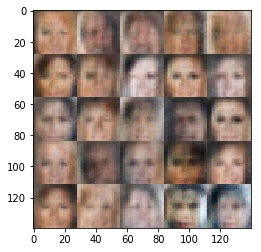

Epoch: 1/1; Batch:  2025; Discriminator Loss: 1.2017... Generator Loss: 0.4175
Epoch: 1/1; Batch:  2050; Discriminator Loss: 1.4878... Generator Loss: 0.3046
Epoch: 1/1; Batch:  2075; Discriminator Loss: 0.3580... Generator Loss: 1.5639
Epoch: 1/1; Batch:  2100; Discriminator Loss: 0.0196... Generator Loss: 6.4384
Epoch: 1/1; Batch:  2125; Discriminator Loss: 0.0431... Generator Loss: 6.9887
Epoch: 1/1; Batch:  2150; Discriminator Loss: 0.0309... Generator Loss: 6.9170
Epoch: 1/1; Batch:  2175; Discriminator Loss: 0.2106... Generator Loss: 2.1038
Epoch: 1/1; Batch:  2200; Discriminator Loss: 0.1969... Generator Loss: 2.2618


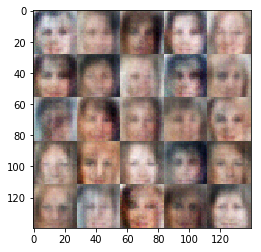

Epoch: 1/1; Batch:  2225; Discriminator Loss: 0.0256... Generator Loss: 9.1222
Epoch: 1/1; Batch:  2250; Discriminator Loss: 0.0344... Generator Loss: 9.8347
Epoch: 1/1; Batch:  2275; Discriminator Loss: 0.1197... Generator Loss: 2.6199
Epoch: 1/1; Batch:  2300; Discriminator Loss: 0.3935... Generator Loss: 1.3345
Epoch: 1/1; Batch:  2325; Discriminator Loss: 0.2478... Generator Loss: 10.3750
Epoch: 1/1; Batch:  2350; Discriminator Loss: 0.0641... Generator Loss: 7.4738
Epoch: 1/1; Batch:  2375; Discriminator Loss: 0.0589... Generator Loss: 6.9098
Epoch: 1/1; Batch:  2400; Discriminator Loss: 0.9251... Generator Loss: 13.0427


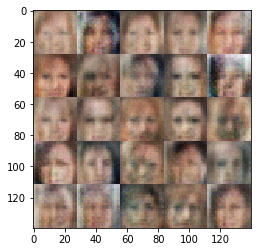

Epoch: 1/1; Batch:  2425; Discriminator Loss: 0.0341... Generator Loss: 6.0860
Epoch: 1/1; Batch:  2450; Discriminator Loss: 0.2665... Generator Loss: 1.6650
Epoch: 1/1; Batch:  2475; Discriminator Loss: 0.1567... Generator Loss: 2.8673
Epoch: 1/1; Batch:  2500; Discriminator Loss: 0.0836... Generator Loss: 10.9756
Epoch: 1/1; Batch:  2525; Discriminator Loss: 0.0778... Generator Loss: 3.1223
Epoch: 1/1; Batch:  2550; Discriminator Loss: 0.0119... Generator Loss: 5.5216
Epoch: 1/1; Batch:  2575; Discriminator Loss: 2.0219... Generator Loss: 0.1738
Epoch: 1/1; Batch:  2600; Discriminator Loss: 0.0721... Generator Loss: 3.3917


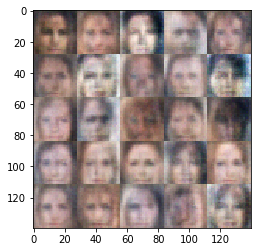

Epoch: 1/1; Batch:  2625; Discriminator Loss: 0.0201... Generator Loss: 6.3778
Epoch: 1/1; Batch:  2650; Discriminator Loss: 0.0993... Generator Loss: 13.2518
Epoch: 1/1; Batch:  2675; Discriminator Loss: 1.0238... Generator Loss: 12.1341
Epoch: 1/1; Batch:  2700; Discriminator Loss: 0.0823... Generator Loss: 3.4709
Epoch: 1/1; Batch:  2725; Discriminator Loss: 0.4454... Generator Loss: 15.2313
Epoch: 1/1; Batch:  2750; Discriminator Loss: 0.0343... Generator Loss: 9.2726
Epoch: 1/1; Batch:  2775; Discriminator Loss: 0.0090... Generator Loss: 10.3049
Epoch: 1/1; Batch:  2800; Discriminator Loss: 0.0603... Generator Loss: 3.5531


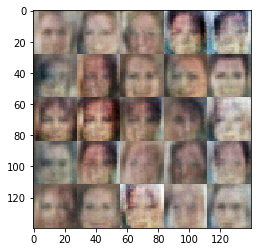

Epoch: 1/1; Batch:  2825; Discriminator Loss: 0.0153... Generator Loss: 11.6261
Epoch: 1/1; Batch:  2850; Discriminator Loss: 0.0540... Generator Loss: 11.9425
Epoch: 1/1; Batch:  2875; Discriminator Loss: 0.0138... Generator Loss: 10.2276
Epoch: 1/1; Batch:  2900; Discriminator Loss: 0.0216... Generator Loss: 10.1526
Epoch: 1/1; Batch:  2925; Discriminator Loss: 0.1084... Generator Loss: 6.1168
Epoch: 1/1; Batch:  2950; Discriminator Loss: 0.0138... Generator Loss: 11.5844
Epoch: 1/1; Batch:  2975; Discriminator Loss: 0.0217... Generator Loss: 11.6865
Epoch: 1/1; Batch:  3000; Discriminator Loss: 0.0405... Generator Loss: 5.9570


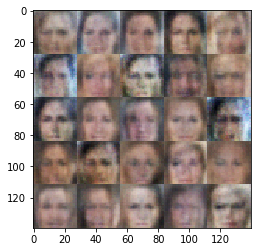

Epoch: 1/1; Batch:  3025; Discriminator Loss: 0.0898... Generator Loss: 3.2016
Epoch: 1/1; Batch:  3050; Discriminator Loss: 0.0128... Generator Loss: 9.8814
Epoch: 1/1; Batch:  3075; Discriminator Loss: 0.0388... Generator Loss: 4.9523
Epoch: 1/1; Batch:  3100; Discriminator Loss: 0.0347... Generator Loss: 8.3171
Epoch: 1/1; Batch:  3125; Discriminator Loss: 0.2556... Generator Loss: 1.6266
Epoch: 1/1; Batch:  3150; Discriminator Loss: 0.5941... Generator Loss: 0.8832


In [61]:
batch_size = 64
z_dim = 100
learning_rate = 0.0001
beta1 = 0.3



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.